# Multi Head Attention

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

In [7]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)


Text(0.5, 1.0, 'qkv distribution')

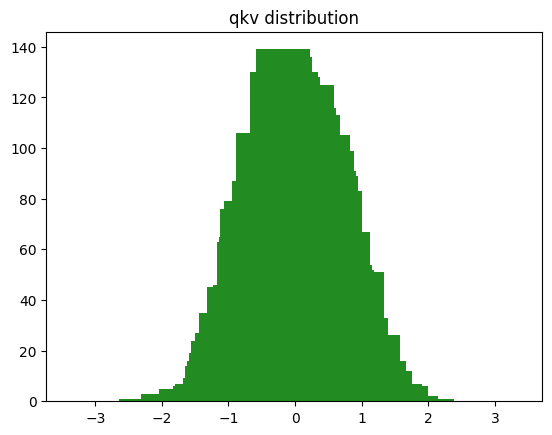

In [8]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [9]:
num_heads = 8
head_dim = d_model //num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3* head_dim)

In [10]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [11]:
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [12]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

# Self attention for multiple heads

For a single head:

$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$ 

In [13]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [14]:
k.T.shape # This transposes the whole matrix and not the last 2 dims

C:\Users\user\AppData\Local\Temp\ipykernel_29284\2101057804.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  k.T.shape # This transposes the whole matrix and not the last 2 dims


torch.Size([64, 4, 8, 1])

In [15]:
y = torch.randn(2, 3)
y

tensor([[ 0.4290,  1.0855, -0.2553],
        [ 0.1708,  1.2541, -2.3500]])

In [16]:
torch.transpose(y, 0, 1)

tensor([[ 0.4290,  0.1708],
        [ 1.0855,  1.2541],
        [-0.2553, -2.3500]])

In [17]:
torch.transpose(y, 1, 0)

tensor([[ 0.4290,  0.1708],
        [ 1.0855,  1.2541],
        [-0.2553, -2.3500]])

In [18]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [19]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [20]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] #Second masked attention head of the first batch

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [21]:
(scaled + mask)[0][0] #First masked attention head of the first batch

tensor([[-0.4089,    -inf,    -inf,    -inf],
        [ 0.1764,  0.2362,    -inf,    -inf],
        [ 0.4890, -0.3433, -0.1193,    -inf],
        [-0.4978, -0.2877, -0.1171, -0.3284]], grad_fn=<SelectBackward0>)

In [22]:
scaled += mask

In [23]:
# Calculating softmax of the second row
x = scaled[0][0][1][0].detach().numpy()
y = scaled[0][0][1][1].detach().numpy()
np.exp(x) / (np.exp(x) + np.exp(y))

0.48505348

In [24]:
attention = F.softmax(scaled, dim=-1)

In [25]:
attention.shape

torch.Size([1, 8, 4, 4])

In [26]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4851, 0.5149, 0.0000, 0.0000],
        [0.5052, 0.2198, 0.2750, 0.0000],
        [0.2048, 0.2527, 0.2998, 0.2427]], grad_fn=<SelectBackward0>)

In [27]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

# Function

In [28]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [29]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [30]:
attention.shape

torch.Size([1, 8, 4, 4])

In [31]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4851, 0.5149, 0.0000, 0.0000],
        [0.5052, 0.2198, 0.2750, 0.0000],
        [0.2048, 0.2527, 0.2998, 0.2427]], grad_fn=<SelectBackward0>)

In [32]:
values.size()

torch.Size([1, 8, 4, 64])

In [33]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [34]:
linear_layer = nn.Linear(d_model, d_model)

In [35]:
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

In [36]:
out

tensor([[[-0.1151, -0.0657, -0.0812,  ...,  0.2201, -0.0023, -0.2572],
         [-0.0590,  0.0143, -0.1821,  ...,  0.1487, -0.1231, -0.0069],
         [ 0.0679, -0.3232,  0.0809,  ..., -0.1643,  0.1897,  0.1378],
         [ 0.4741,  0.4095, -0.2022,  ..., -0.0513,  0.3714, -0.0451]]],
       grad_fn=<ViewBackward0>)

# Class

In [40]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


## Input

In [42]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)

out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
